In [1]:
import os
os.chdir('/fs/ess/PAS1348/nagesh/cutandrun_hannahs/output/mapping/bam/rmdups/macs3')
notebook_path = os.getcwd()
print(notebook_path)

/fs/ess/PAS1348/nagesh/cutandrun_hannahs/output/mapping/bam/rmdups/macs3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline 

In [3]:
df = pd.read_csv("H82_c_MYC_bigwigcompare2_2024_09_05_16_29_54_bedmap_EPDnew.bed", sep="\t", names=['a','b','c','d','e','f'] )

In [4]:
df = df.assign(f=df['f'].str.split(';')).explode('f')

In [5]:
df.head()

,a,b,c,d,e,f
0,chr1,976663,976713,id-3211,7.90,PERM1_1
1,chr1,976713,976763,id-3212,3.34,PERM1_1
2,chr1,1000463,1000513,id-3519,0.54,ISG15_2
3,chr1,1000513,1000563,id-3520,5.70,ISG15_2
4,chr1,1013413,1013463,id-3735,16.42,ISG15_1


Text(0, 0.5, 'Percentage')

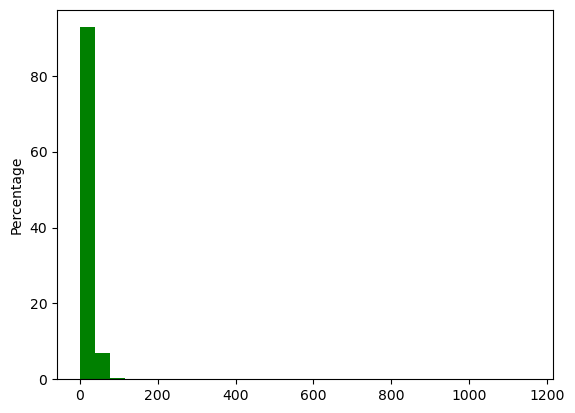

In [6]:
plt.hist(df['e'], bins=30, color='g', weights=np.ones_like(df['e']) / len(df['e']) * 100)
plt.ylabel('Percentage')

In [7]:
df = df[df['e'] > 0]

Text(0, 0.5, 'Percentage')

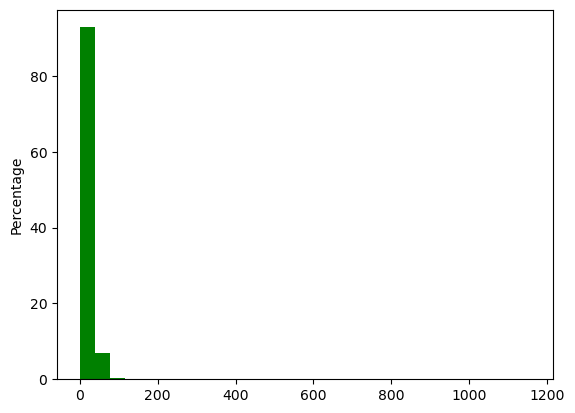

In [8]:
plt.hist(df['e'], bins=30, color='g', weights=np.ones_like(df['e']) / len(df['e']) * 100)
plt.ylabel('Percentage')

In [9]:
df['e'].describe()

count    43049.000000
mean        15.638976
std         19.805589
min          0.020000
25%          4.420000
50%         11.600000
75%         22.340000
max       1156.620000
Name: e, dtype: float64

In [10]:
df = df[df['e'] >= 1]
df = df[df['e'] <= 10]

Text(0, 0.5, 'Percentage')

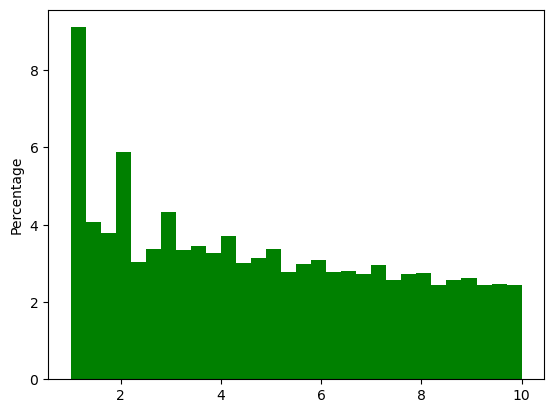

In [11]:
plt.hist(df['e'], bins=30, color='g', weights=np.ones_like(df['e']) / len(df['e']) * 100)
plt.ylabel('Percentage')

In [12]:
df['e'].describe()

count    16854.000000
mean         4.825517
std          2.685415
min          1.000000
25%          2.400000
50%          4.550000
75%          7.080000
max         10.000000
Name: e, dtype: float64

Text(0, 0.5, 'Percentage')

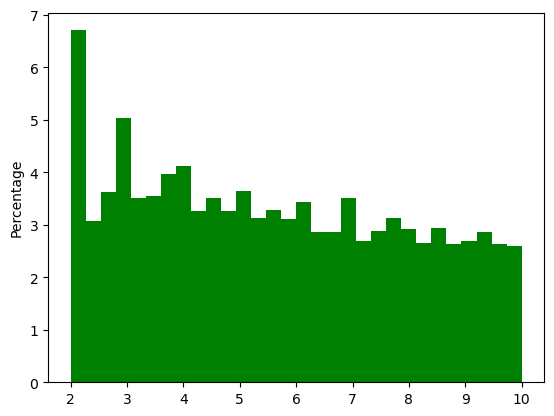

In [13]:
df = df[df['e'] >= 2]
plt.hist(df['e'], bins=30, color='g', weights=np.ones_like(df['e']) / len(df['e']) * 100)
plt.ylabel('Percentage')

In [14]:
df['e'].describe()

count    13768.000000
mean         5.604919
std          2.342218
min          2.000000
25%          3.560000
50%          5.440000
75%          7.600000
max         10.000000
Name: e, dtype: float64

In [15]:
df.head()

,a,b,c,d,e,f
0,chr1,976663,976713,id-3211,7.90,PERM1_1
1,chr1,976713,976763,id-3212,3.34,PERM1_1
3,chr1,1000513,1000563,id-3520,5.70,ISG15_2
6,chr1,1173813,1173863,id-5932,4.20,TTLL10_1
8,chr1,1179613,1179663,id-6043,5.42,TTLL10_2


In [16]:
# Step 1: Read the Hs_EPDnew.bed file to get TSS positions
bed_df = pd.read_csv("Hs_EPDnew.bed", sep=" ", header=None, 
                     names=["chromosome", "region_start", "region_end", "name", "score", "strand", "thick_start", "thick_end"])

In [17]:
bed_df.head()

,chromosome,region_start,region_end,name,score,strand,thick_start,thick_end
0,chr1,959245,959305,NOC2L_1,900,-,959245,959256
1,chr1,960583,960643,KLHL17_1,900,+,960632,960643
2,chr1,966432,966492,PLEKHN1_1,900,+,966481,966492
3,chr1,976670,976730,PERM1_1,900,-,976670,976681
4,chr1,1000086,1000146,HES4_1,900,-,1000086,1000097


In [18]:
# Step 2: Calculate TSS position for each transcript based on strand information in the BED file
tss_positions = {}
for idx, row in bed_df.iterrows():
    transcript = row["name"]
    chrom = row["chromosome"]
    
    # For + strand, TSS is at thick_start
    # For - strand, TSS is at thick_end
    if row["strand"] == "+":
        tss = row["thick_start"]
    else:  # "-" strand
        tss = row["thick_end"]
    
    tss_positions[transcript] = {
        "chromosome": chrom,
        "tss": tss,
        "strand": row["strand"]
    }

In [19]:
# Step 3: Process the original dataframe (df) to identify merged peaks
transcript_peaks = {}
for transcript, group in df.groupby('f'):
    # Skip transcripts that don't have TSS information
    if transcript not in tss_positions:
        continue
        
    # Sort by chromosome and position
    group = group.sort_values(['a', 'b'])
    
    # Process each chromosome separately
    peaks = []
    for chrom, chrom_group in group.groupby('a'):
        # Skip if chromosome doesn't match the one in TSS data
        if chrom != tss_positions[transcript]["chromosome"]:
            continue
            
        chrom_group = chrom_group.sort_values('b')
        
        # Initialize with first region
        if len(chrom_group) > 0:
            current_peak = {
                "chromosome": chrom,
                "start": chrom_group.iloc[0]['b'],
                "end": chrom_group.iloc[0]['c'],
                "height": chrom_group.iloc[0]['e']
            }
            
            # Merge adjacent regions
            for idx, row in chrom_group.iloc[1:].iterrows():
                if row['b'] == current_peak["end"]:
                    # Merge this region with the current peak
                    current_peak["end"] = row['c']
                    current_peak["height"] = max(current_peak["height"], row['e'])
                else:
                    # Store the previous peak and start a new one
                    peaks.append(current_peak)
                    current_peak = {
                        "chromosome": chrom,
                        "start": row['b'],
                        "end": row['c'],
                        "height": row['e']
                    }
            
            # Add the last peak
            peaks.append(current_peak)
    
    transcript_peaks[transcript] = peaks

In [20]:
# Step 4: Identify transcripts with peaks ONLY in the +/-500 range (not in 500-3000 range)
transcripts_to_retain = []
for transcript, peaks in transcript_peaks.items():
    tss = tss_positions[transcript]["tss"]
    
    # Check for peaks within +/-500 of TSS
    has_peaks_near_tss = False
    has_peaks_in_forbidden_range = False
    
    for peak in peaks:
        # Check if peak is within +/-500 of TSS
        if peak["start"] <= tss + 500 and peak["end"] >= tss - 500:
            has_peaks_near_tss = True
        
        # Check if peak is in the forbidden range: 500-3000 from TSS (either direction)
        # Two cases to check:
        # 1. Peak starts in the +500 to +3000 range
        if peak["start"] > tss + 500 and peak["start"] <= tss + 3000:
            has_peaks_in_forbidden_range = True
        # 2. Peak ends in the -3000 to -500 range
        if peak["end"] < tss - 500 and peak["end"] >= tss - 3000:
            has_peaks_in_forbidden_range = True
    
    # Retain transcript if it has peaks near TSS AND doesn't have peaks in the forbidden range
    if has_peaks_near_tss and not has_peaks_in_forbidden_range:
        transcripts_to_retain.append(transcript)

In [21]:
# Step 5: Filter the original dataframe
filtered_df = df[df['f'].isin(transcripts_to_retain)]

In [22]:
filtered_df.head()

,a,b,c,d,e,f
0,chr1,976663,976713,id-3211,7.90,PERM1_1
1,chr1,976713,976763,id-3212,3.34,PERM1_1
3,chr1,1000513,1000563,id-3520,5.70,ISG15_2
6,chr1,1173813,1173863,id-5932,4.20,TTLL10_1
8,chr1,1179613,1179663,id-6043,5.42,TTLL10_2


In [23]:
filtered_df['e'].describe()

count    13768.000000
mean         5.604919
std          2.342218
min          2.000000
25%          3.560000
50%          5.440000
75%          7.600000
max         10.000000
Name: e, dtype: float64

In [24]:
# Step 6: Display results
print(f"Found {len(transcripts_to_retain)} transcripts with:")
print(f"  - At least one peak within +/-500 of TSS")
print(f"  - NO peaks in the 500-3000 range of TSS")
print(f"Original dataframe had {len(df['f'].unique())} unique transcripts")
print(f"Filtered dataframe has {len(filtered_df['f'].unique())} unique transcripts")

Found 9129 transcripts with:
  - At least one peak within +/-500 of TSS
  - NO peaks in the 500-3000 range of TSS
Original dataframe had 9129 unique transcripts
Filtered dataframe has 9129 unique transcripts


In [25]:
filtered_df.to_csv('H82_cMYC_transcripts_with_peaks_500_range.tsv', sep='\t', index=False)

In [18]:
gene=df['f'].str.split('_').str[0].to_frame()

In [19]:
gene.head()

,f
0,PERM1
1,PERM1
3,ISG15
6,TTLL10
8,TTLL10


In [20]:
gene_count=gene['f'].value_counts()

In [21]:
gene_count=gene_count.sort_values()

In [22]:
gene_count.head()

f
AMMECR1L    1
UGGT1       1
CCDC74B     1
SMPD4       1
FAM168B     1
Name: count, dtype: int64

<Axes: xlabel='f'>

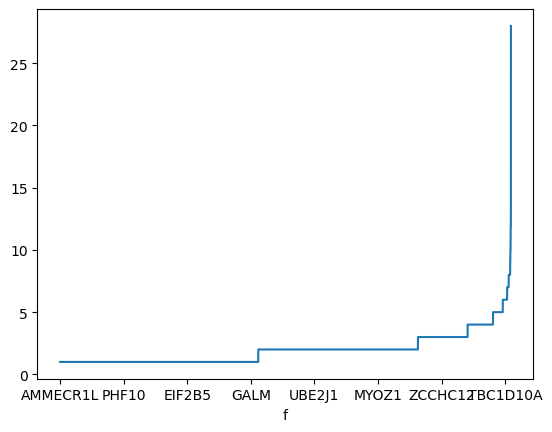

In [23]:
gene_count.plot(kind='line')

In [24]:
gene_count.describe()

count    7091.000000
mean        1.941616
std         1.242060
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        28.000000
Name: count, dtype: float64

In [25]:
start = int(len(gene_count)*0.25)
end = len(gene_count) - start
df_25_75 = gene_count.iloc[start:end]

In [26]:
df_25_75.describe()

count    3547.000000
mean        1.620806
std         0.485255
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: count, dtype: float64

In [27]:
len(gene_count)

7091

In [28]:
int(len(gene_count)*0.25)

1772

In [29]:
int(len(gene_count)*0.75)

5318

In [30]:
int(len(gene_count)*0.75)-int(len(gene_count)*0.25)

3546

In [31]:
7017-1754

5263

In [32]:
df_25_75.head()

f
BTBD1     1
SH3GL3    1
AKAP13    1
KLHL25    1
PCDH18    1
Name: count, dtype: int64

In [33]:
ids=df_25_75.to_frame().reset_index()

In [34]:
ids.head()

,f,count
0,BTBD1,1
1,SH3GL3,1
2,AKAP13,1
3,KLHL25,1
4,PCDH18,1


In [35]:
ids['f'].to_csv('H82_cMYC_25_75_ids.txt', header=False, index=False)

In [36]:
ids.describe()

,count
count,3547.000000
mean,1.620806
std,0.485255
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


In [39]:
print(os.getcwd())

/fs/ess/PAS1348/nagesh/cutandrun_hannahs/output/mapping/bam/rmdups/macs3
